# 模拟价格时间序列的直觉
本文档由SiyuanLi整理, 邮箱: lisiyuansven@foxmail.com

金融数据的模拟(或者说"生成")是一个复杂的问题, 也容易面临"这样做有什么意义"的诘问. 但有时, 我们希望快速检验某个策略的可行性, 或想研究其泛化能力, 这时候就可以考虑采用一些预设的分布函数来模拟. 

如果直接采用随机数做价格的模拟, 很容易获得与真实数据相去甚远的结果, 原因有二:

1.股票(也可以是其他金融资产, 后续例子都是股票是因为比较直观易懂)的价格往往是前后高度相关的. 这一领域有一个经典的笑话: 在对明天的收盘价的估计量中, 表现最好的是今天的收盘价. 因为一个股票今天价格100元, 那么明天很可能是103元, 或者96元, 但通常不会是299元或者43元. 

2.股票的价格不应该跌破0元. 在经济意义上, 股票是对公司净资产的所有权, 是正资产或者零资产, 但通常不会是负资产. 

最简单的价格模拟策略, 是从一些分布中随机生成日收益率数据, 再计算累计收益率, 进而结合初始价格转化为股票价格. 

# 1. 为什么模拟收益率而非价格

## 1.1 直接模拟价格

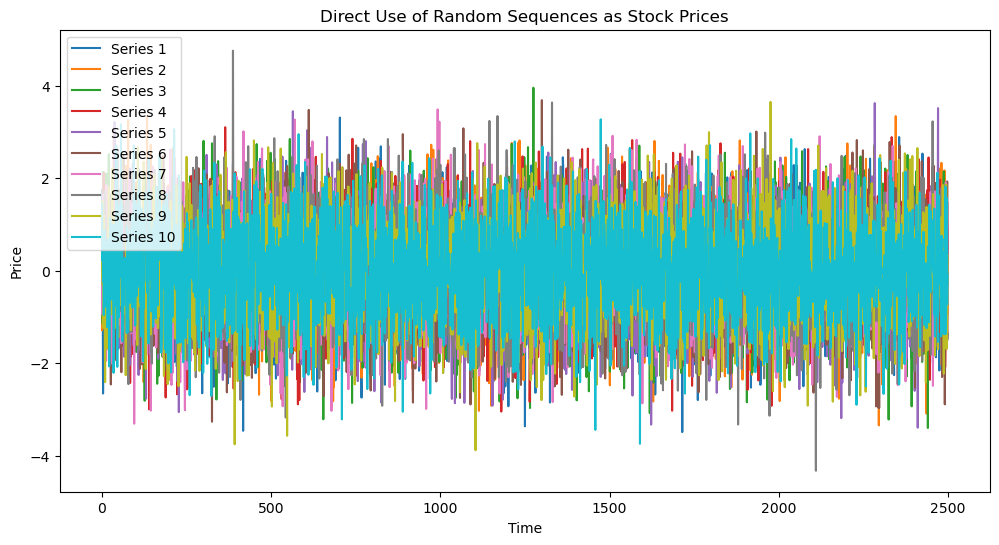

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 设置随机种子
np.random.seed(11)

# 生成10个长度为2500的标准正态分布随机数序列
sequences = np.random.randn(10, 2500)

# 绘制图像，直接使用生成的随机序列作为价格
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.plot(sequences[i], label=f'Series {i+1}')
plt.title('Direct Use of Random Sequences as Stock Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()



这显然不是合格的价格数据. 明显长得不像股市数据. 

让我们换个思路, 把模拟来的数据当作股票的增量, 观察股价的变化. 

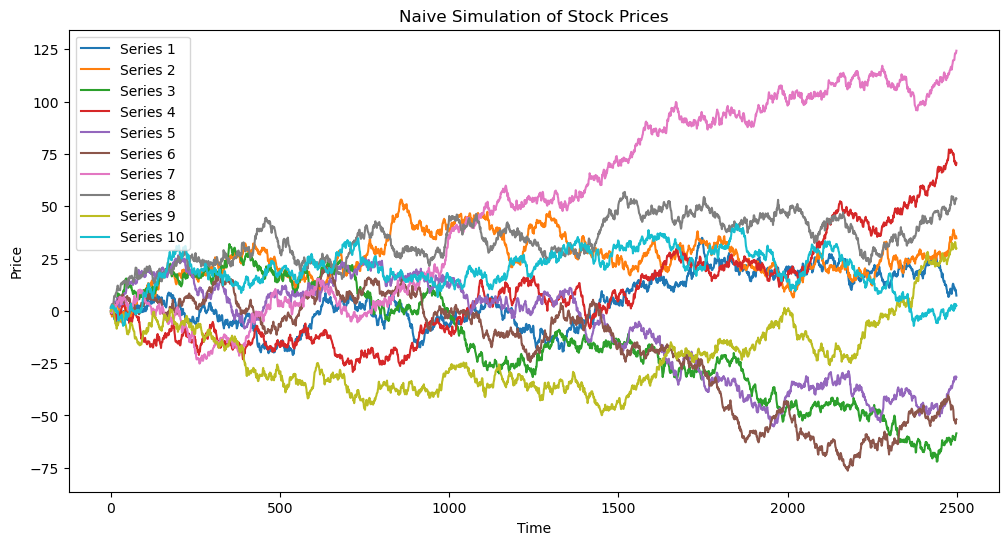

In [2]:
# 对每个序列进行累加以模拟股票价格的走势
stock_prices = np.cumsum(sequences, axis=1)

# 绘制图像
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.plot(stock_prices[i], label=f'Series {i+1}')
plt.title('Naive Simulation of Stock Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

这个价格看起来更像回事了, 但是出现了价格跌破0的情况, 不符合经济意义. 如果加上一些放缩, 可以避免这种情况, 但本身就不切实际的模拟数据会更加失真. 

## 1.2 通过收益率模拟价格

让我们回忆专栏文章[风险收益数据与Python处理--CH1--收益率](https://zhuanlan.zhihu.com/p/702833752), 其中有收益率和累计收益率的介绍. 我们尝试用正态分布取日收益率, 然后计算每个股票的累计收益率. (累计收益率+1)就相当于其初始价格为1时的价格. 

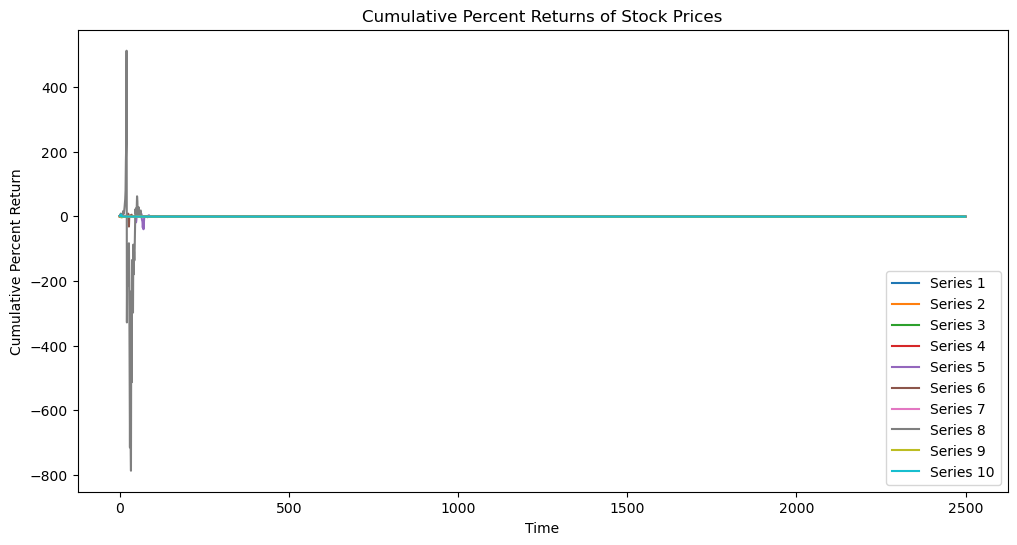

In [3]:
# 使用百分比收益率计算累计收益率，其中R为随机生成的收益率序列
# 公式：CR[t-k, t] = (Π(R_t-i + 1)) - 1, R_t-i 是指从t-i时刻的收益率

# 计算累计收益率
# 累乘每一天的(1 + 收益率)
cumulative_returns_percent = np.cumprod(1 + sequences, axis=1) - 1

# 绘制累计收益率图像，使用百分比收益率
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.plot(cumulative_returns_percent[i], label=f'Series {i+1}')
plt.title('Cumulative Percent Returns of Stock Prices')
plt.xlabel('Time')
plt.ylabel('Cumulative Percent Return')
plt.legend()
plt.show()

从标准正态分布中模拟收益率的尝试是失败的, 如果你画出日收益率的分布图就会发现, 这日收益率相较实际情况太大, 这是由于标准正态分布的标准差为1, 而实际股票的日收益率标准差很少有这么大. 

正态分布的$[\mu - 3\cdot \sigma, \mu + 3\cdot \sigma]$范围中大约包含了99.73%的样本, 这意味着标准正态分布的最大和最小值常在3, -3左右. 事实上, 只要日收益率取到一个(-1)或者以下的数字, 股票的累计收益率就会直接归零. 

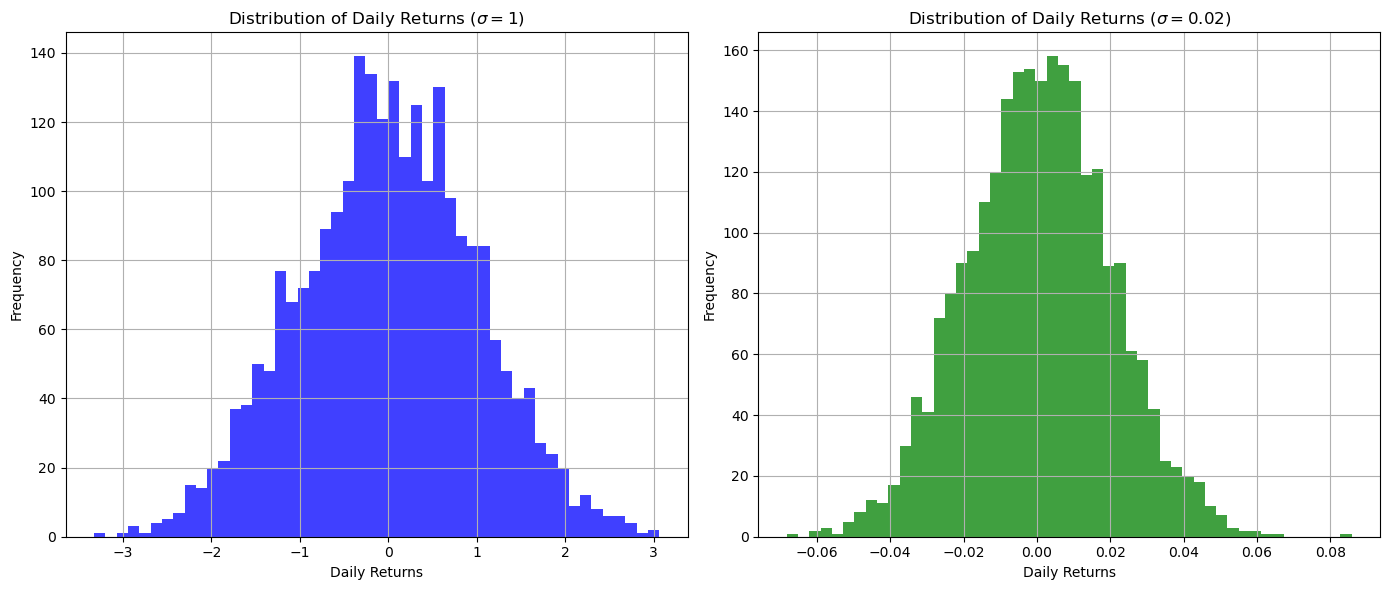

In [4]:
# 生成两组数据，一组σ=1，另一组σ=0.02
returns_sigma_1 = np.random.randn(2500)
returns_sigma_002 = np.random.normal(0, 0.02, 2500)

# 绘制两组数据的分布图
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# σ=1的分布图
axes[0].hist(returns_sigma_1, bins=50, alpha=0.75, color='blue')
axes[0].set_title('Distribution of Daily Returns ($\sigma=1$)')
axes[0].set_xlabel('Daily Returns')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

# σ=0.02的分布图
axes[1].hist(returns_sigma_002, bins=50, alpha=0.75, color='green')
axes[1].set_title('Distribution of Daily Returns ($\sigma=0.02$)')
axes[1].set_xlabel('Daily Returns')
axes[1].set_ylabel('Frequency')
axes[1].grid(True)

plt.tight_layout()
plt.show()

### 1.2.1 正态分布模拟价格

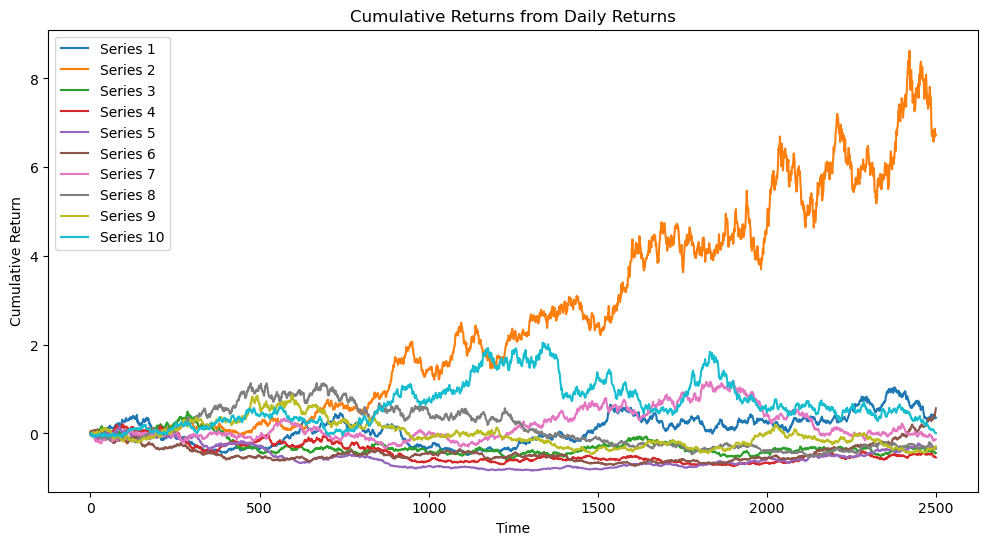

In [5]:
# 生成10个长度为2500的来自均值为0，标准差为0.02的正态分布的随机数序列
daily_returns = np.random.normal(0, 0.02, (10, 2500))

# 使用百分比收益率计算累计收益率
# 累乘每一天的(1 + 收益率)
cumulative_returns_from_daily = np.cumprod(1 + daily_returns, axis=1) - 1

# 绘制累计收益率图像
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.plot(cumulative_returns_from_daily[i], label=f'Series {i+1}')
plt.title('Cumulative Returns from Daily Returns')
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

至此, 我们得到了一个基本无害的累计收益率图. 欢迎你调整其中的均值和方差, 观察累计收益率的变化. 

### 1.2.2 均匀分布模拟价格

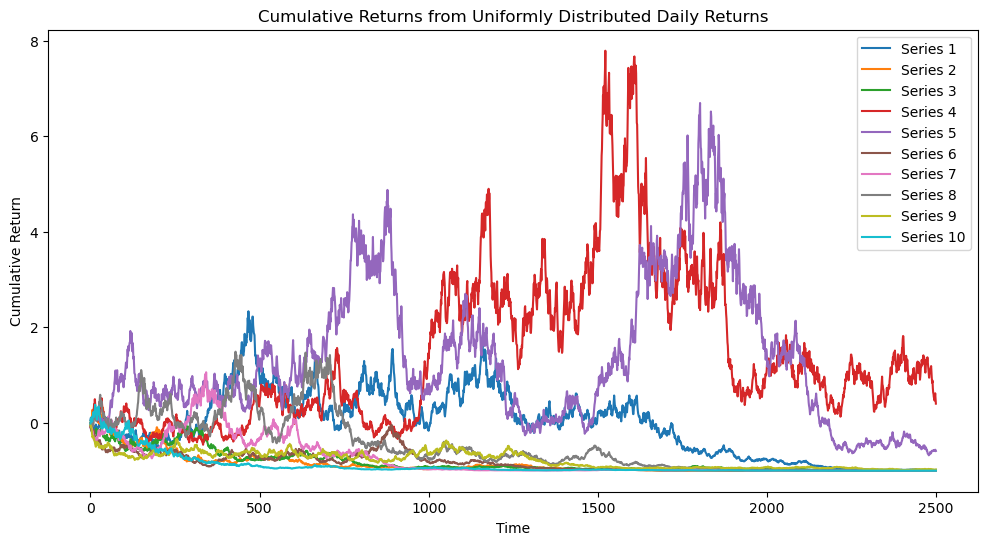

In [6]:
daily_returns = np.random.uniform(-0.09, 0.09, (10, 2500))

cumulative_returns_from_daily = np.cumprod(1 + daily_returns, axis=1) - 1

# 绘制累计收益率图像
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.plot(cumulative_returns_from_daily[i], label=f'Series {i+1}')
plt.title('Cumulative Returns from Uniformly Distributed Daily Returns')
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

### 1.2.3 二项分布模拟价格

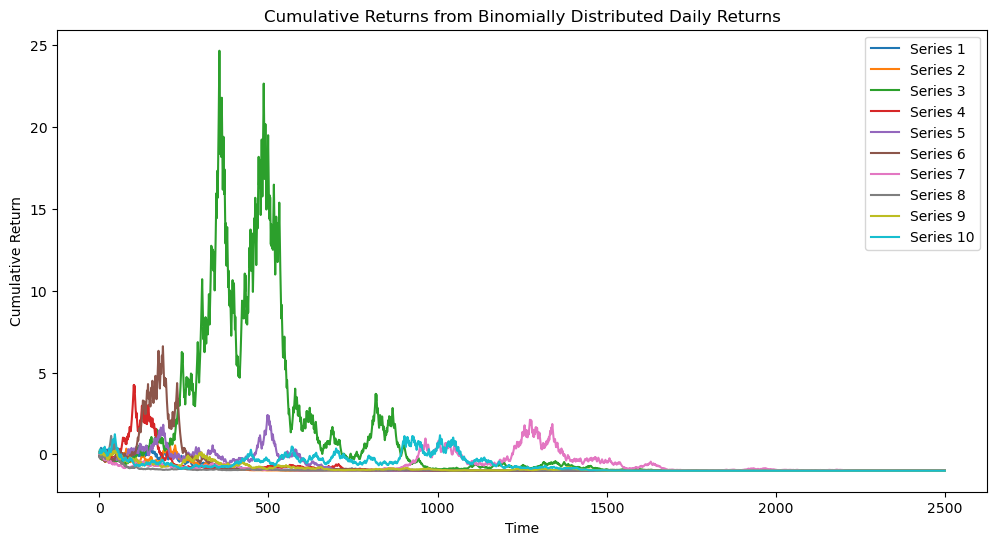

In [7]:
# 参数设置
n_trials = 1        # 每天只有一个试验
p_up = 0.5          # 上涨概率
up_return = 0.09    # 上涨返回
down_return = -0.09 # 下跌返回

# 生成10个长度为2500的二项分布的随机数序列
# np.random.binomial返回的是成功的次数，因此我们需要将它转换为收益率
daily_returns = np.random.binomial(n_trials, p_up, (10, 2500))
daily_returns = np.where(daily_returns == 1, up_return, down_return)

# 使用百分比收益率计算累计收益率
# 累乘每一天的(1 + 收益率)
cumulative_returns_from_daily = np.cumprod(1 + daily_returns, axis=1) - 1

# 绘制累计收益率图像
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.plot(cumulative_returns_from_daily[i], label=f'Series {i+1}')
plt.title('Cumulative Returns from Binomially Distributed Daily Returns')
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

## 1.3 "价格服从对数正态分布"意味着什么

在BS模型等公式中，你可能会见到"价格服从对数正态分布"的表述。这种表述源于从收益率的正态分布推导出价格的对数正态分布。为说明这一点，我们定义百分比收益率 $R_t$，表示为 

$$R_t = \frac{P_t - P_{t-1}}{P_{t-1}} = \frac{P_t}{P_{t-1}} - 1$$

这意味着当天的股票价格是前一天价格的 $(R_t + 1)$ 倍。

基于此, 累计收益率 $CR[t-k, t]$ 表示为 
$$CR[t-k, t] = \left(\prod_{i=0}^k (R_{t-i} + 1)\right) - 1$$

这表明在考虑的时间段内，每一天的价格是前一天价格的 $(R_{t-i} + 1)$ 倍。

我们考虑 $t$ 时刻与 $t-k$ 时刻之间的价格比 $\frac{P_t}{P_{t-k}}$，它等于连续 $k$ 天内每天的价格比的乘积，即 

$$\frac{P_t}{P_{t-k}} = \prod_{i=0}^k (R_{t-i} + 1)$$

通过对这个价格比取自然对数，我们得到 
$$\ln\left(\frac{P_t}{P_{t-k}}\right) = \sum_{i=0}^k \ln(R_{t-i} + 1)$$

如果假设 $R_t$ 服从正态分布，或者更准确地说 $\ln(R_t + 1)$ 服从正态分布，那么它们的和也服从正态分布。由于 $\ln\left(\frac{P_t}{P_{t-k}}\right)$ 是正态分布，因此 $\frac{P_t}{P_{t-k}}$ 服从对数正态分布。


# 2. 标准正态分布参数的选择

本章我们探讨标准正态分布的参数的调整对日收益率, 累计收益率有怎样的影响. 

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew
from tqdm import tqdm

# np.random.seed(11)

def plot_return_distributions_complete(generate_returns_func, 
                                       num_days=2750, 
                                       num_simulations=100000, 
                                       log_scale=False, 
                                       diff_sigma=False, 
                                       sigma=1, 
                                       return_data=False):

    """
    使用指定的收益率生成函数来模拟并绘制日收益率和累计收益率的分布图。
    
    参数:
        generate_returns_func (function): 用于生成日收益率的函数。
        num_days (int): 要模拟的天数。
        num_simulations (int): 要运行的模拟次数。
        log_scale (bool): 图表的y轴是否使用对数刻度。
        diff_sigma (bool): 是否使用不同的标准差生成收益率。
        sigma (float): 如果使用不同标准差，该参数指定标准差的值。
        return_data (bool): 是否除了绘图外还返回模拟数据。

    返回:
        dict: 可选；如果return_data为True，返回包含日收益率和累计收益率数据的字典。
    """

    # Initialize array to store cumulative returns
    cumulative_returns = []

    if diff_sigma:
        # Simulate and accumulate returns with progress bar
        for _ in tqdm(range(num_simulations), desc="Simulating Returns"):
            returns = generate_returns_func(num_days=num_days, sigma=sigma)
            cumulative_return = np.prod(1 + returns) - 1
            cumulative_returns.append(cumulative_return)

            # Generate a sample of daily returns for visualization
            sample_daily_returns = generate_returns_func(num_days=num_days, sigma=sigma)
    else:
        # Simulate and accumulate returns with progress bar
        for _ in tqdm(range(num_simulations), desc="Simulating Returns"):
            returns = generate_returns_func(num_days)
            cumulative_return = np.prod(1 + returns) - 1
            cumulative_returns.append(cumulative_return)

            # Generate a sample of daily returns for visualization
            sample_daily_returns = generate_returns_func(num_days)
    

    # Calculate skewness and kurtosis
    daily_skewness = skew(sample_daily_returns)
    daily_kurtosis = kurtosis(sample_daily_returns)
    cumulative_skewness = skew(cumulative_returns)
    cumulative_kurtosis = kurtosis(cumulative_returns)

    # Plot daily returns histogram only
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.hist(sample_daily_returns, bins=500, alpha=0.7, color='blue', label='Histogram')
    mean_daily_returns = np.mean(sample_daily_returns)
    median_daily_returns = np.median(sample_daily_returns)
    plt.axvline(mean_daily_returns, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: {mean_daily_returns:.5f}')
    plt.axvline(median_daily_returns, color='green', linestyle='dashed', linewidth=1.5, label=f'Median: {median_daily_returns:.5f}')

    if diff_sigma:
        plt.title(f'Histogram of Daily Returns (Sample, σ={sigma:.5f})\n Mean: {sample_daily_returns.mean():.5f}, Std: {sample_daily_returns.std():.5f} \nSkewness: {daily_skewness:.2f}, Kurtosis: {daily_kurtosis:.2f}')
    else:
        plt.title(f'Histogram of Daily Returns (Sample)\n Mean: {sample_daily_returns.mean():.5f}, Std: {sample_daily_returns.std():.5f} \nSkewness: {daily_skewness:.2f}, Kurtosis: {daily_kurtosis:.2f}')

    plt.xlabel('Daily Return')
    plt.ylabel('Frequency')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.hist(cumulative_returns, bins=200, alpha=0.7, color='blue', label='Histogram')
    mean_cumulative_returns = np.mean(cumulative_returns)
    median_cumulative_returns = np.median(cumulative_returns)
    plt.axvline(mean_cumulative_returns, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: {mean_cumulative_returns:.5f}')
    plt.axvline(median_cumulative_returns, color='green', linestyle='dashed', linewidth=1.5, label=f'Median: {median_cumulative_returns:.5f}')
    plt.title(f'Histogram of Cumulative Returns\nMean: {np.array(cumulative_returns).mean():.5f}, Std: {np.array(cumulative_returns).std():.5f} \nSkewness: {cumulative_skewness:.2f}, Kurtosis: {cumulative_kurtosis:.2f}')
    plt.xlabel('Cumulative Return')
    plt.ylabel('Frequency')
    
    if log_scale:
        plt.yscale('log')
    
    plt.legend()
    plt.tight_layout()
    plt.show()

    if return_data:
        return {
            'Cumulative Returns': cumulative_returns,
            'Skewness (Daily Returns)': daily_skewness,
            'Kurtosis (Daily Returns)': daily_kurtosis,
            'Skewness (Cumulative Returns)': cumulative_skewness,
            'Kurtosis (Cumulative Returns)': cumulative_kurtosis
        }

## 2.1 标准正态分布

意义不大, 有一个-1就都-1

Simulating Returns: 100%|██████████| 100000/100000 [00:17<00:00, 5565.15it/s]
C:\Users\SiyuanLi\AppData\Local\Temp\ipykernel_8024\1698813407.py:58: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  cumulative_skewness = skew(cumulative_returns)
C:\Users\SiyuanLi\AppData\Local\Temp\ipykernel_8024\1698813407.py:59: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  cumulative_kurtosis = kurtosis(cumulative_returns)


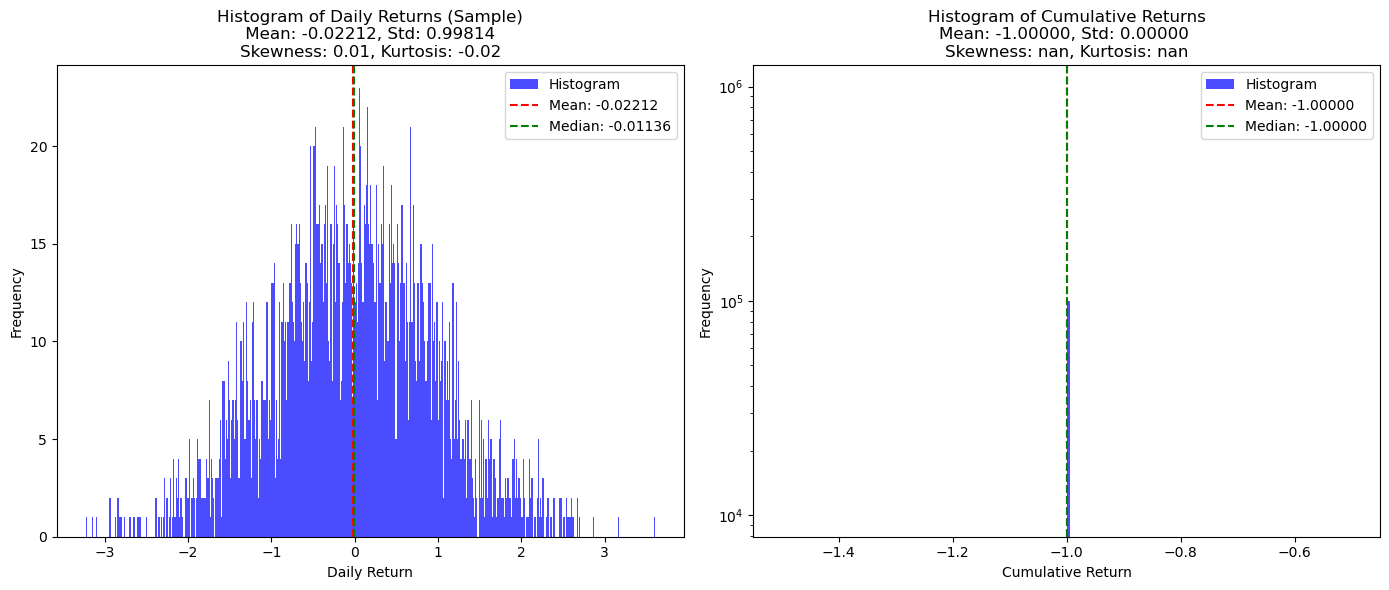

In [9]:
def generate_returns_normal(num_days):
    """生成日收益率，从标准正态分布"""
    daily_returns = np.random.normal(0, 1, num_days)
    return daily_returns

plot_return_distributions_complete(generate_returns_normal, log_scale=True)

Simulating Returns: 100%|██████████| 100000/100000 [00:15<00:00, 6503.14it/s]


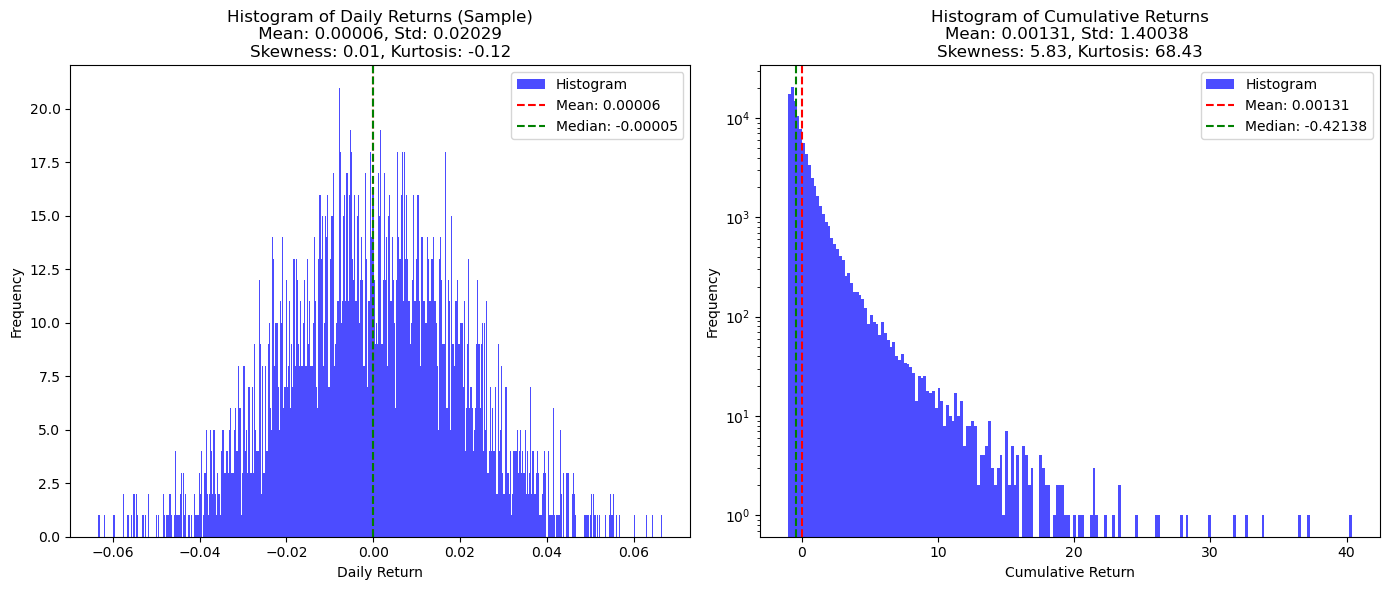

In [22]:
def generate_returns_normal(num_days):
    """生成日收益率，从标准正态分布"""
    daily_returns = np.random.normal(0, 0.02, num_days)
    return daily_returns

return_data = plot_return_distributions_complete(generate_returns_normal, log_scale=True, return_data=True)

## 2.2 均值为0正态分布 不同$\sigma$

Simulating Returns: 100%|██████████| 1000000/1000000 [02:37<00:00, 6341.04it/s]


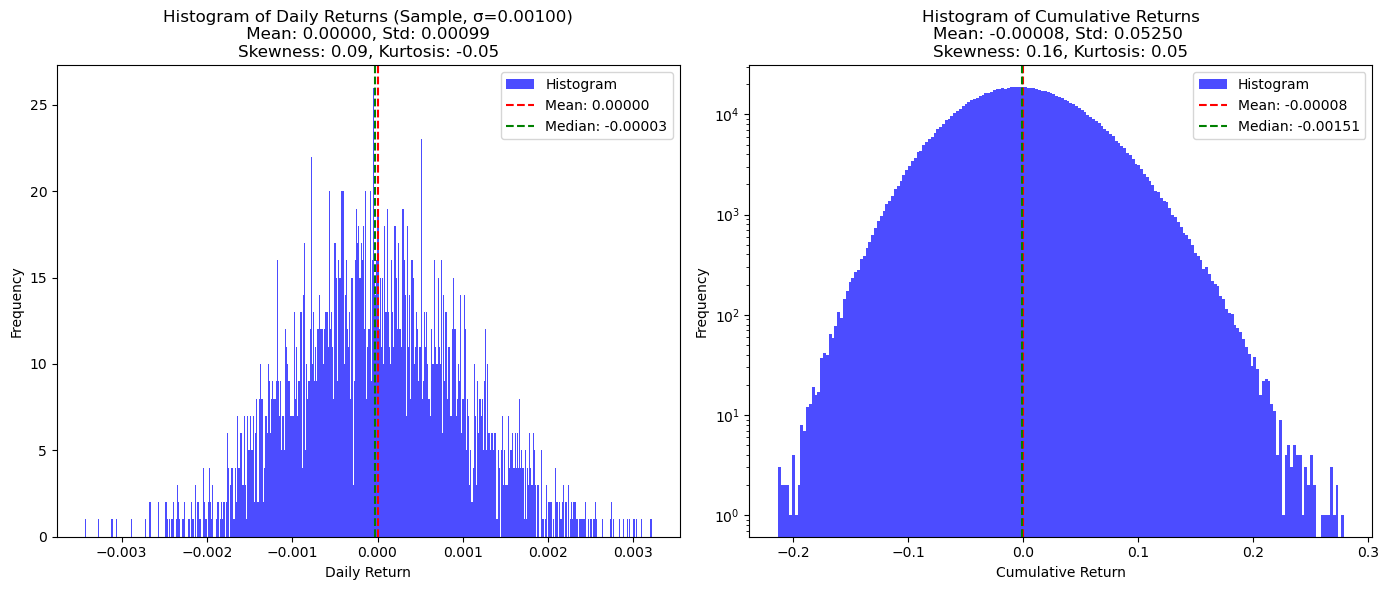

Simulating Returns: 100%|██████████| 1000000/1000000 [02:28<00:00, 6714.04it/s]


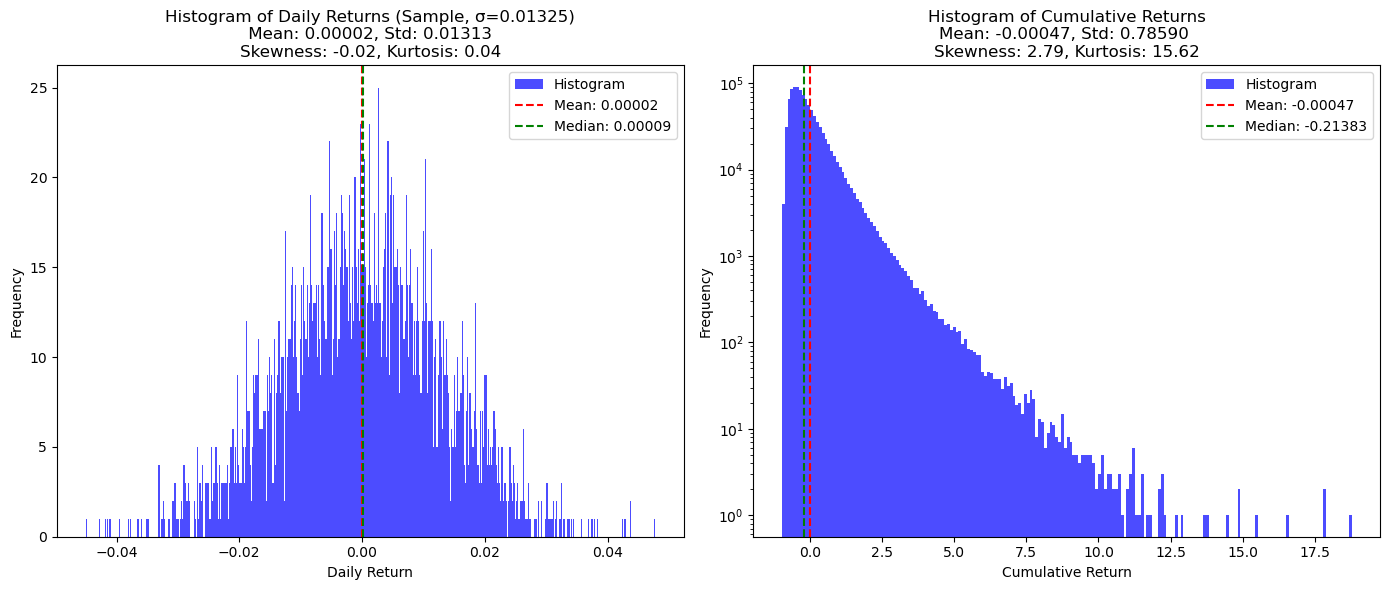

Simulating Returns: 100%|██████████| 1000000/1000000 [02:32<00:00, 6536.71it/s]


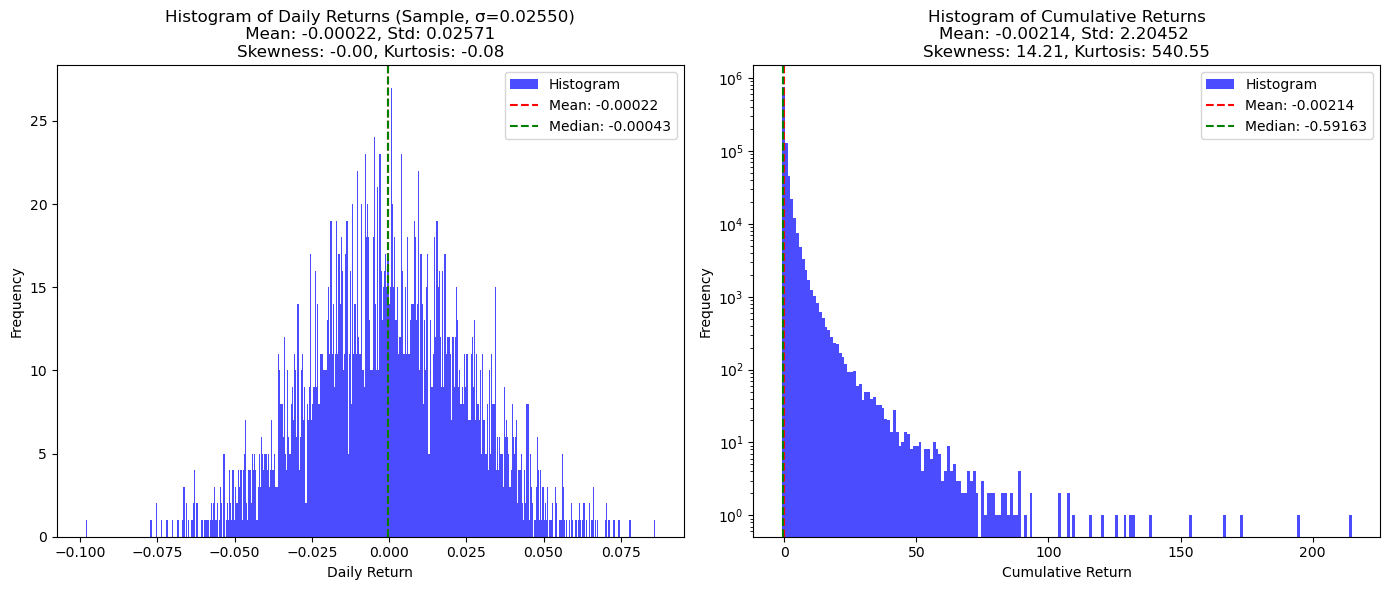

Simulating Returns: 100%|██████████| 1000000/1000000 [02:34<00:00, 6481.58it/s]


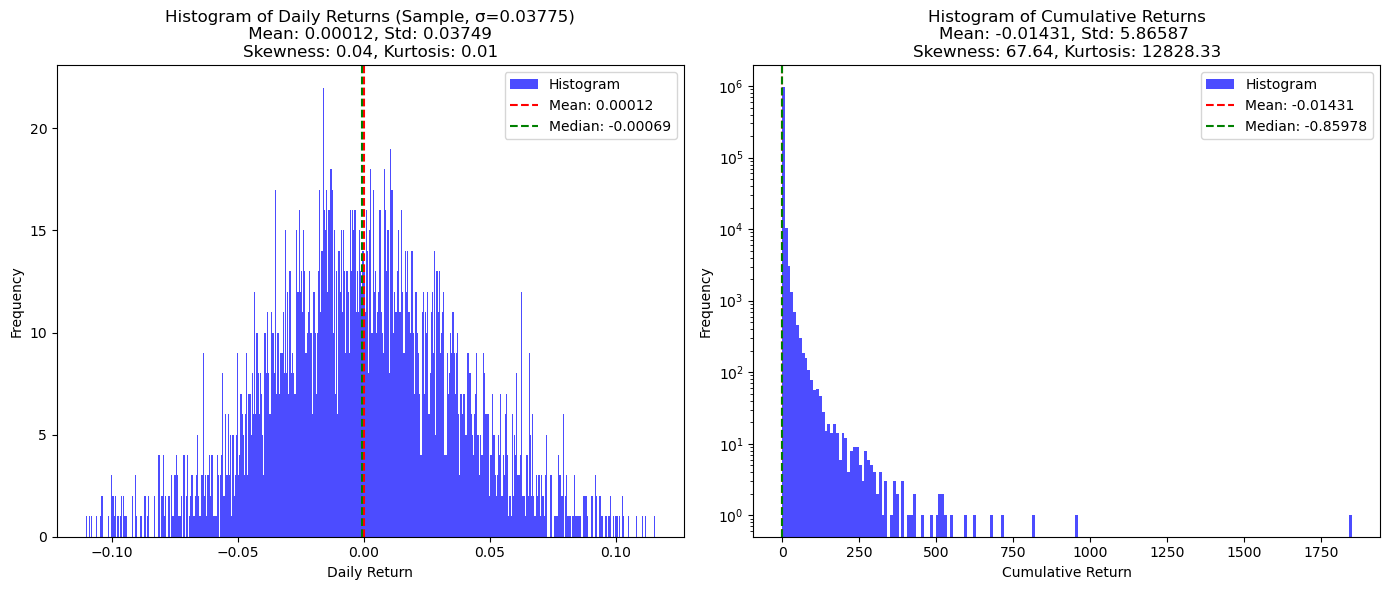

Simulating Returns: 100%|██████████| 1000000/1000000 [02:32<00:00, 6542.38it/s]


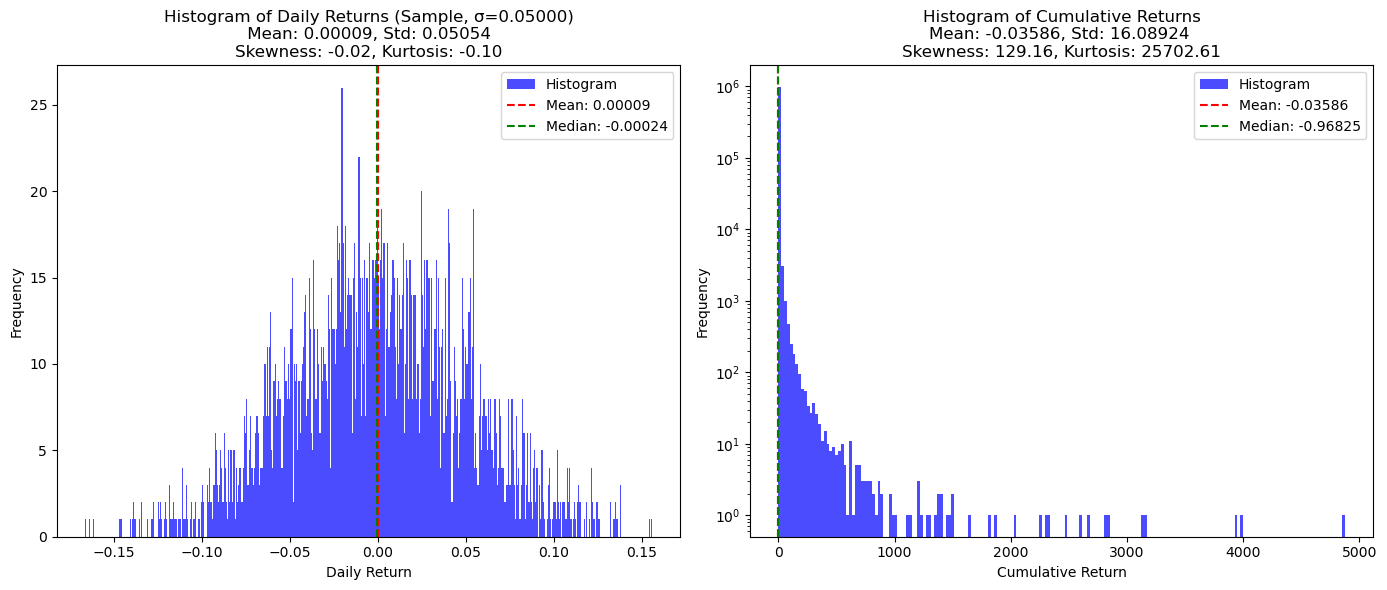

In [11]:
def generate_returns_normal_diff_sigma(num_days, sigma):
    """生成日收益率，从标准正态分布"""
    daily_returns = np.random.normal(0, sigma, num_days)
    return daily_returns


for sigma in np.linspace(0.001, 0.05, 5):
    plot_return_distributions_complete(generate_returns_normal_diff_sigma, log_scale=True, diff_sigma=True, sigma=sigma, num_simulations=1000000)

# 3. 在特定区间生成收益率的方法

## 3.1 标准正态分布线性压缩到[-0.02,0.02]

这是一种不可取的办法, 因为正态分布取到极端值以后, 再进行线性压缩, 会改变样本的均值. 这会连带导致累计收益率出现离谱的极端值. 


Simulating Returns: 100%|██████████| 1000000/1000000 [03:20<00:00, 4995.28it/s]


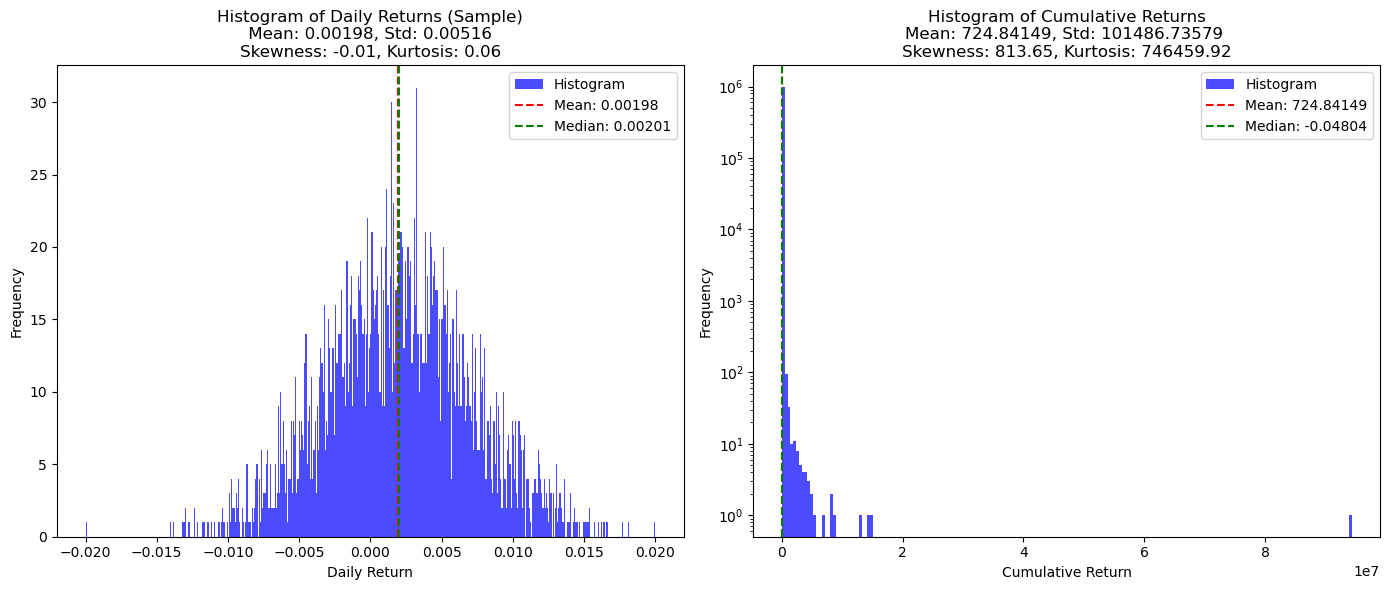

In [12]:
def generate_returns_normal_lim(num_days):
    """生成日收益率，从标准正态分布，压缩到[-0.02, 0.02]之间"""
    daily_returns = np.random.normal(0, 1, num_days)
    min_return, max_return = -0.02, 0.02
    rescaled = min_return + (max_return - min_return) * (daily_returns - np.min(daily_returns)) / (np.max(daily_returns) - np.min(daily_returns))
    return rescaled

plot_return_distributions_complete(generate_returns_normal_lim, num_simulations=1000000, log_scale=True)

## 3.2 用sigmoid压缩到01再线性压缩到-0.02, 0.02

Simulating Returns: 100%|██████████| 100000/100000 [00:32<00:00, 3095.79it/s]


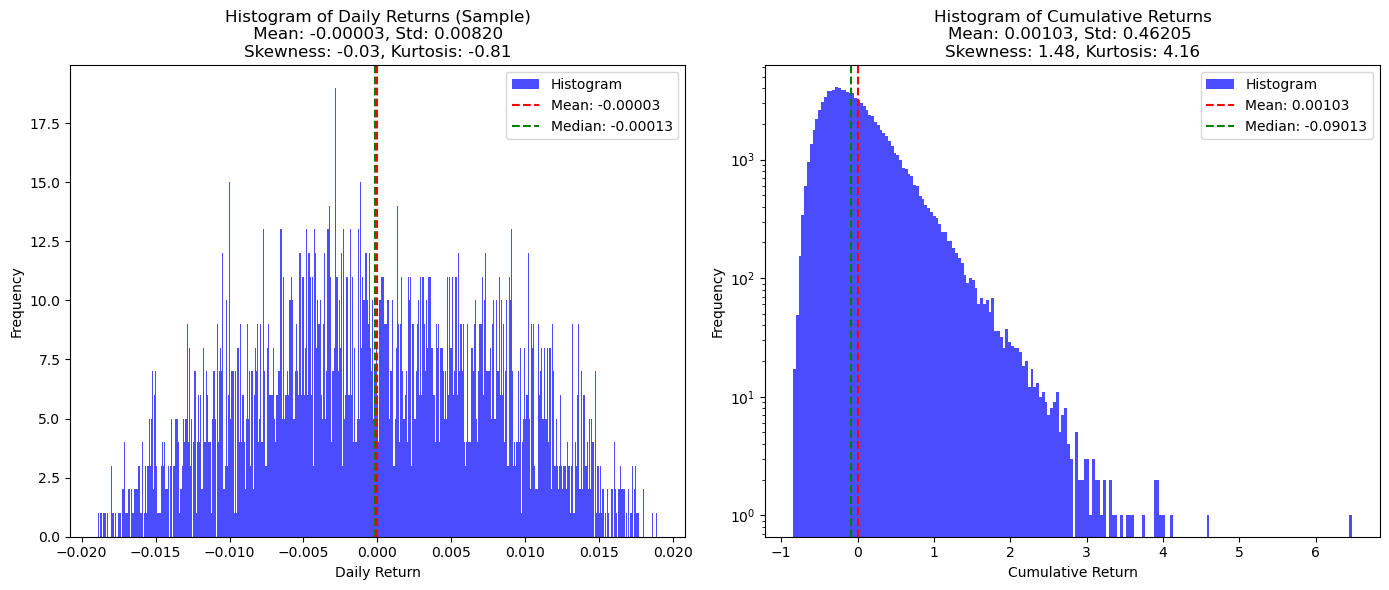

In [13]:
def sigmoid(x):
    """ Sigmoid函数实现 """
    return 1 / (1 + np.exp(-x))

def generate_returns_sigmoid(num_days):
    """ 生成日收益率，通过sigmoid函数压缩，然后线性压缩到[-0.02, 0.02] """
    daily_returns = np.random.normal(0, 1, num_days)
    compressed_returns = sigmoid(daily_returns)
    min_return, max_return = -0.02, 0.02
    rescaled_returns = min_return + (max_return - min_return) * compressed_returns
    return rescaled_returns

plot_return_distributions_complete(generate_returns_sigmoid, num_simulations=100000, log_scale=True)

下图展示了应用不同压缩方法后得到的日收益率. 

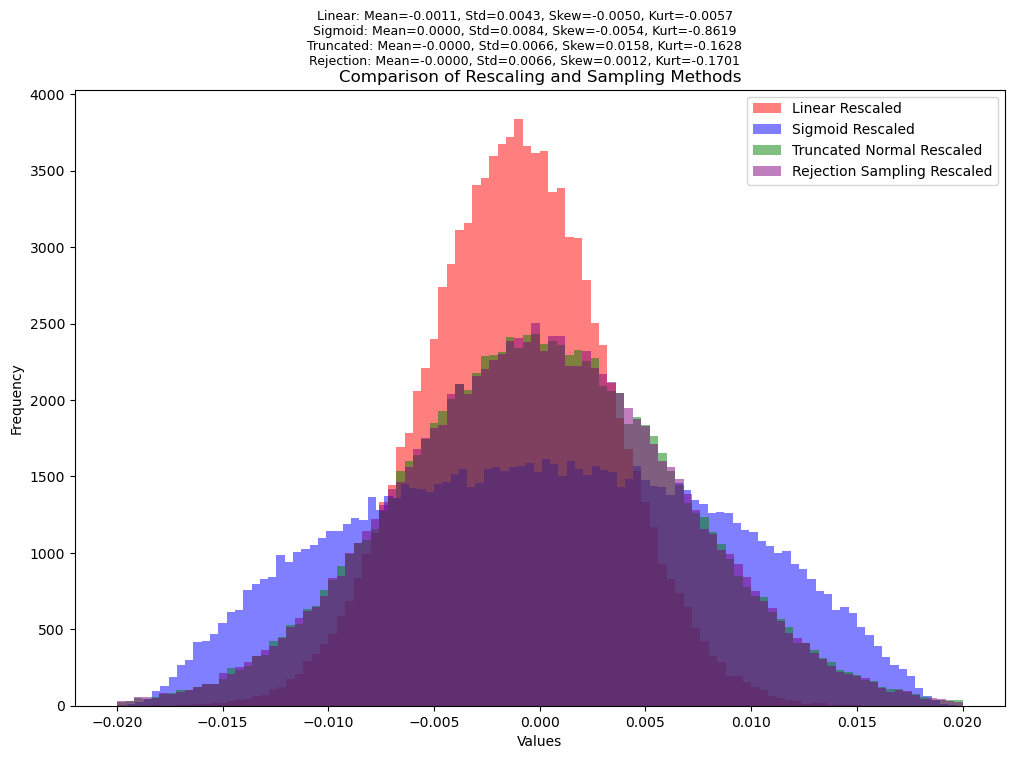

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import truncnorm

# 定义sigmoid和线性压缩函数
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def linear_rescale(data, min_return, max_return):
    return min_return + (max_return - min_return) * (data - np.min(data)) / (np.max(data) - np.min(data))

def calculate_statistics(data):
    mean = np.mean(data)
    std_dev = np.std(data)
    skewness = stats.skew(data)
    kurtosis = stats.kurtosis(data)
    return mean, std_dev, skewness, kurtosis

def generate_truncated_normal(num_samples, lower_bound, upper_bound, mu, sigma):
    a, b = (lower_bound - mu) / sigma, (upper_bound - mu) / sigma
    return truncnorm.rvs(a, b, loc=mu, scale=sigma, size=num_samples)

def generate_rejection_sampling(num_samples, target_mean=0, target_std=1, acceptance_interval=(-3, 3)):
    samples = []
    while len(samples) < num_samples:
        x = np.random.normal(target_mean, target_std)
        if acceptance_interval[0] <= x <= acceptance_interval[1]:
            samples.append(x)
    return np.array(samples)

# 设置参数
num_samples = 100000
data = np.random.normal(0, 1, num_samples)

linear_rescaled = linear_rescale(data, -0.02, 0.02)
sigmoid_rescaled = -0.02 + 0.04 * sigmoid(data)
truncated_data = generate_truncated_normal(num_samples, -3, 3, 0, 1)
truncated_rescaled = linear_rescale(truncated_data, -0.02, 0.02)
rejection_samples = generate_rejection_sampling(num_samples)
rejection_rescaled = linear_rescale(rejection_samples, -0.02, 0.02)

# 计算统计特征
stats_linear = calculate_statistics(linear_rescaled)
stats_sigmoid = calculate_statistics(sigmoid_rescaled)
stats_truncated = calculate_statistics(truncated_rescaled)
stats_rejection = calculate_statistics(rejection_rescaled)

# 绘制所有方法的直方图
plt.figure(figsize=(12, 8))
plt.hist(linear_rescaled, bins=100, color='red', alpha=0.5, label='Linear Rescaled')
plt.hist(sigmoid_rescaled, bins=100, color='blue', alpha=0.5, label='Sigmoid Rescaled')
plt.hist(truncated_rescaled, bins=100, color='green', alpha=0.5, label='Truncated Normal Rescaled')
plt.hist(rejection_rescaled, bins=100, color='purple', alpha=0.5, label='Rejection Sampling Rescaled')

# 构建统计标注作为副标题
stats_texts = f"Linear: Mean={stats_linear[0]:.4f}, Std={stats_linear[1]:.4f}, Skew={stats_linear[2]:.4f}, Kurt={stats_linear[3]:.4f}\n" \
               f"Sigmoid: Mean={stats_sigmoid[0]:.4f}, Std={stats_sigmoid[1]:.4f}, Skew={stats_sigmoid[2]:.4f}, Kurt={stats_sigmoid[3]:.4f}\n" \
               f"Truncated: Mean={stats_truncated[0]:.4f}, Std={stats_truncated[1]:.4f}, Skew={stats_truncated[2]:.4f}, Kurt={stats_truncated[3]:.4f}\n" \
               f"Rejection: Mean={stats_rejection[0]:.4f}, Std={stats_rejection[1]:.4f}, Skew={stats_rejection[2]:.4f}, Kurt={stats_rejection[3]:.4f}"

plt.title("Comparison of Rescaling and Sampling Methods")
plt.suptitle(stats_texts, fontsize=9)
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.legend()
plt.show()


## 3.3 标准正态分布对[-0.02,0.02]取clip

大过最大值的就按最大值算, 小过最小值的就按最小值算

Simulating Returns: 100%|██████████| 100000/100000 [00:18<00:00, 5515.59it/s]


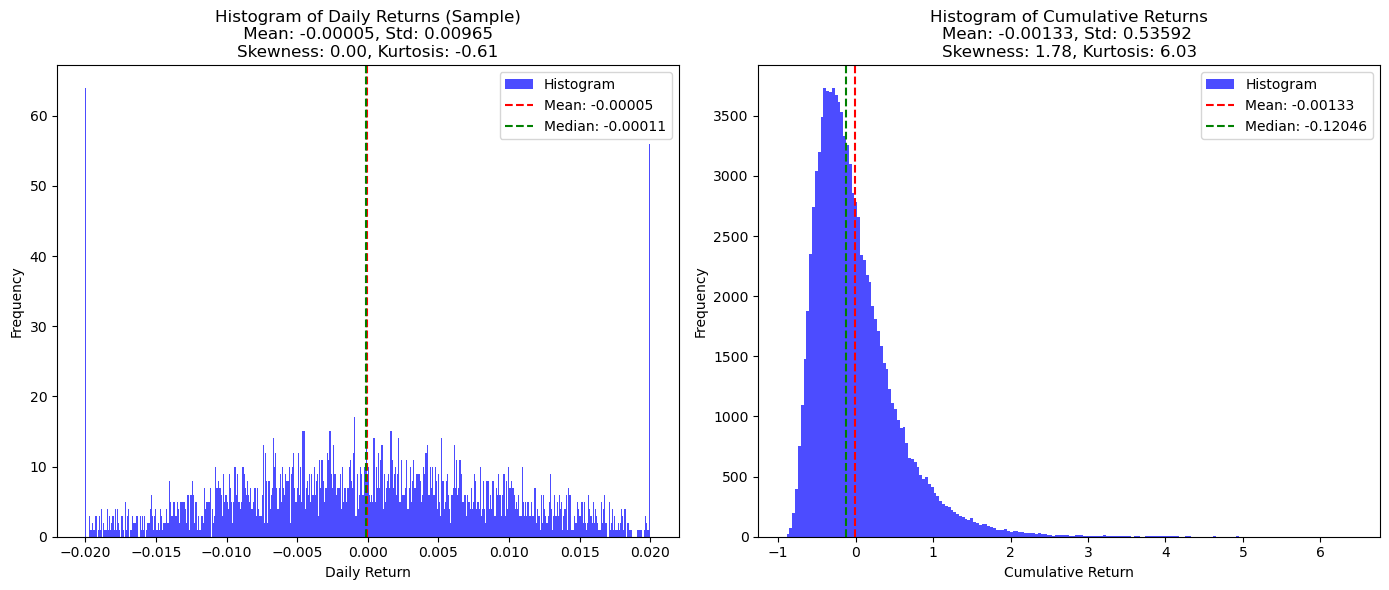

In [15]:
def generate_returns_clip(num_days):
    """Generate daily returns from a standard normal distribution and clip to [-0.02, 0.02]."""
    daily_returns = np.random.normal(0, 0.01, num_days)
    clipped_returns = np.clip(daily_returns, -0.02, 0.02)
    return clipped_returns

# 执行新的收益率生成函数的示例并绘制分布图
plot_return_distributions_complete(generate_returns_clip)

## 3.4 均匀分布在[-0.02,0.02]


Simulating Returns: 100%|██████████| 100000/100000 [00:07<00:00, 14274.48it/s]


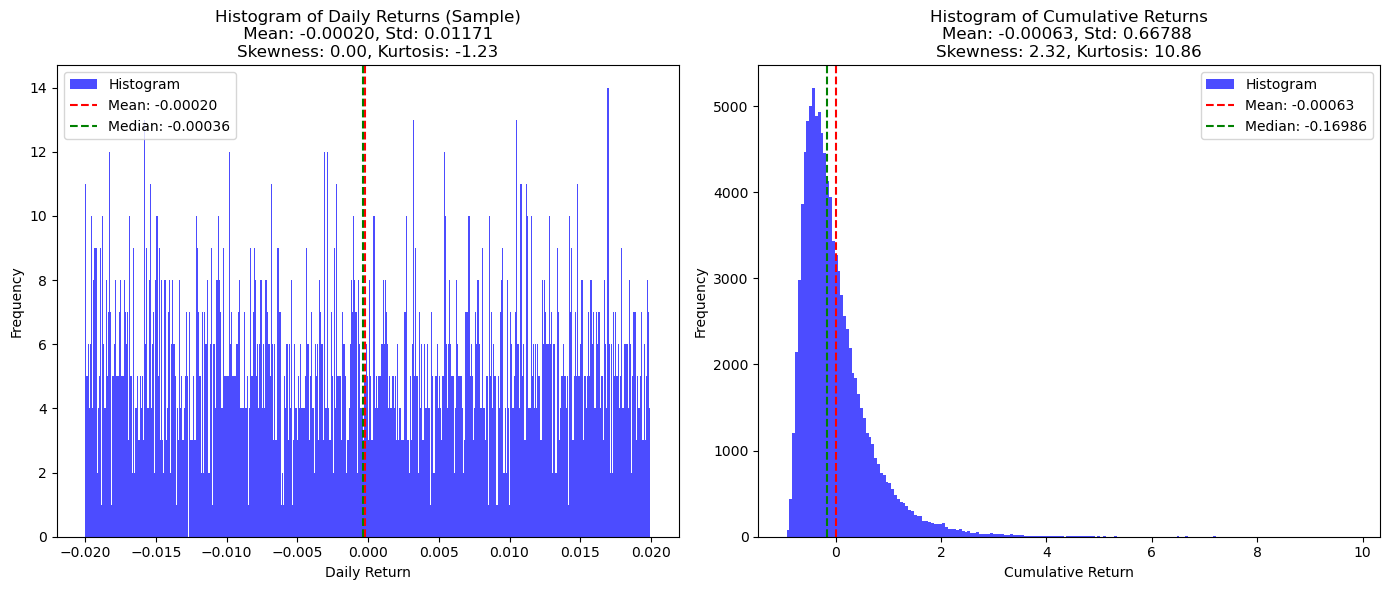

In [16]:
def generate_returns_uniform(num_days):
    """生成日收益率，从[-0.02, 0.02]之间的均匀分布"""
    return np.random.uniform(-0.02, 0.02, num_days)

plot_return_distributions_complete(generate_returns_uniform)

## 3.5 二项分布在{-0.02,0.02}

Simulating Returns: 100%|██████████| 100000/100000 [00:15<00:00, 6621.62it/s]


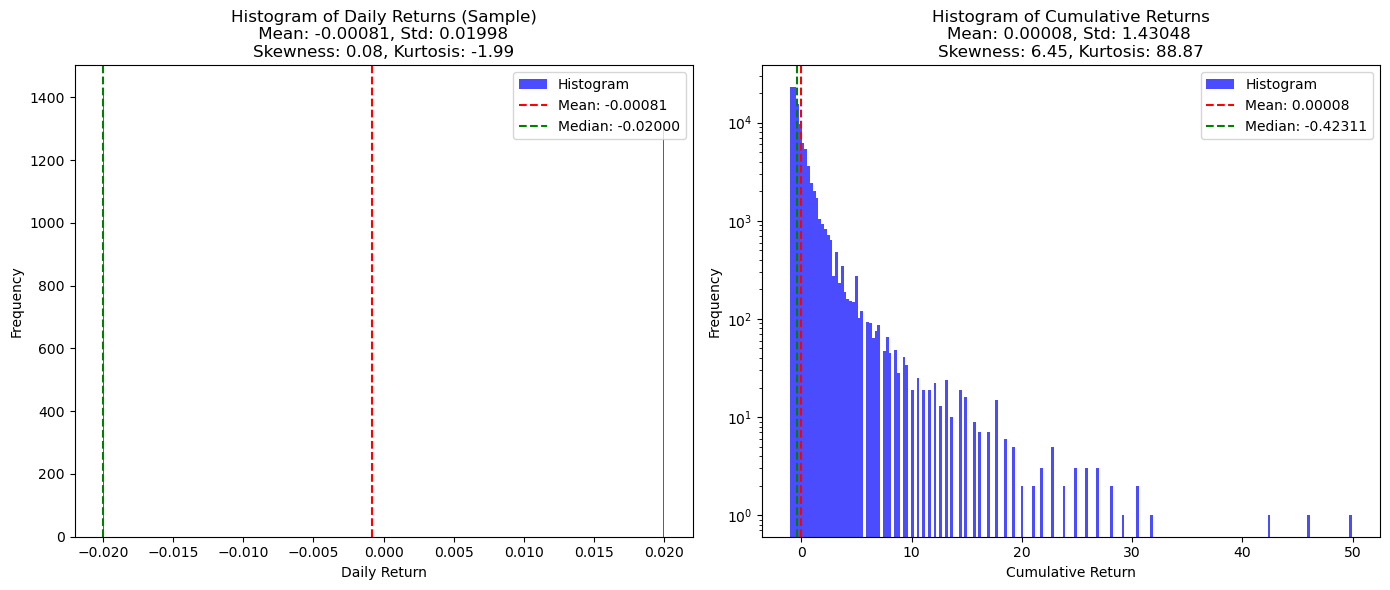

In [17]:
def generate_returns_bio(num_days):
    """在{-0.02, 0.02}之间随机取日收益率"""
    return (np.random.binomial(1,0.5,size=num_days)-0.5)/0.5*0.02

plot_return_distributions_complete(generate_returns_bio, num_simulations=100000, log_scale=True)

In [18]:
(1-0.08)**1375 * (1+0.08)**1375 - 1

-0.9998534700522679

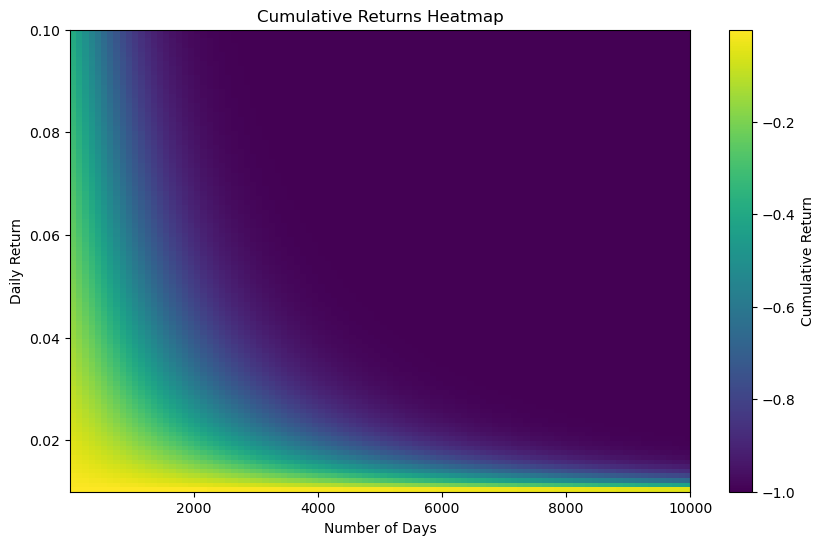

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# 定义日收益率和天数的范围
daily_returns = np.linspace(0.01, 0.1, 100)
num_days = np.linspace(10, 10000, 100)

# 创建网格
daily_returns_grid, num_days_grid = np.meshgrid(daily_returns, num_days)

# 计算累计收益率
cumulative_returns = (1 - daily_returns_grid**2) ** (num_days_grid / 2) - 1

# 绘制热力图
plt.figure(figsize=(10, 6))
plt.imshow(cumulative_returns, aspect='auto', cmap='viridis', origin='lower',
           extent=[num_days.min(), num_days.max(), daily_returns.min(), daily_returns.max()])
plt.colorbar(label='Cumulative Return')
plt.xlabel('Number of Days')
plt.ylabel('Daily Return')
plt.title('Cumulative Returns Heatmap')
plt.show()


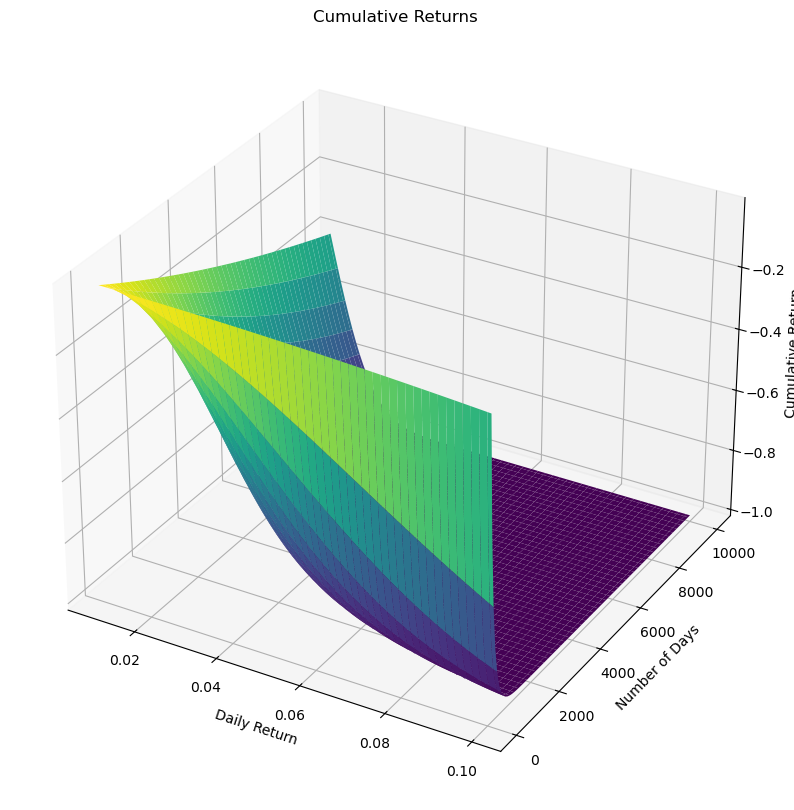

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# 绘制3D图像
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# 画图
ax.plot_surface(daily_returns_grid, num_days_grid, cumulative_returns, cmap='viridis')

# 设置标签
ax.set_title('Cumulative Returns')
ax.set_xlabel('Daily Return')
ax.set_ylabel('Number of Days')
ax.set_zlabel('Cumulative Return')

# 显示图像
plt.show()

Processing R values: 100%|██████████| 100/100 [13:21<00:00,  8.01s/it]


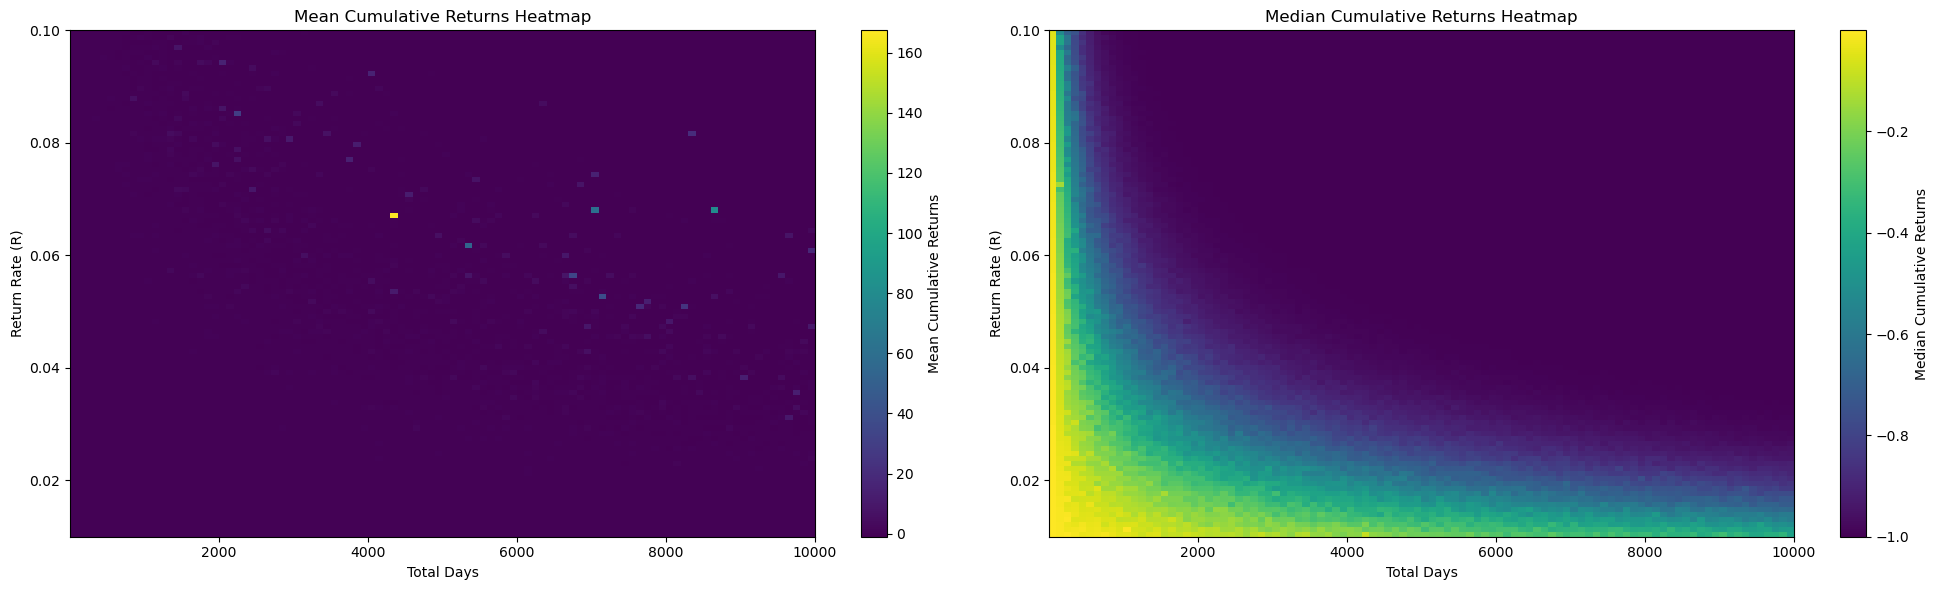

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# 参数设置
R_values = np.linspace(0.01, 0.1, 100)
days_values = np.linspace(10, 10000, 100, dtype=int)
num_experiments = 1000

# 存储结果
mean_cumulative_returns = np.zeros((len(R_values), len(days_values)))
median_cumulative_returns = np.zeros((len(R_values), len(days_values)))

# 进行实验
for i, R in tqdm(enumerate(R_values), total=len(R_values), desc="Processing R values"):
    for j, days in enumerate(days_values):
        cumulative_returns = []
        for _ in range(num_experiments):
            daily_returns = np.random.choice([-R, R], size=days)
            cumulative_return = np.prod(1 + daily_returns) - 1
            cumulative_returns.append(cumulative_return)
        mean_cumulative_returns[i, j] = np.mean(cumulative_returns)
        median_cumulative_returns[i, j] = np.median(cumulative_returns)

# 绘制热力图
X, Y = np.meshgrid(days_values, R_values)

plt.figure(figsize=(20, 6))

# 左图：均值累计收益率
plt.subplot(1, 2, 1)
plt.imshow(mean_cumulative_returns, aspect='auto', cmap='viridis', origin='lower',
           extent=[days_values.min(), days_values.max(), R_values.min(), R_values.max()])
plt.colorbar(label='Mean Cumulative Returns')
plt.xlabel('Total Days')
plt.ylabel('Return Rate (R)')
plt.title('Mean Cumulative Returns Heatmap')

# 右图：中位数累计收益率
plt.subplot(1, 2, 2)
plt.imshow(median_cumulative_returns, aspect='auto', cmap='viridis', origin='lower',
           extent=[days_values.min(), days_values.max(), R_values.min(), R_values.max()])
plt.colorbar(label='Median Cumulative Returns')
plt.xlabel('Total Days')
plt.ylabel('Return Rate (R)')
plt.title('Median Cumulative Returns Heatmap')

plt.tight_layout()
plt.show()

# 4. 对数收益率和对数正态分布